This assignment is inspired by **AlternativeData.ipyn**b and **BitcoinLSTM.ipynb** to scrap data from DataGov and predict time-series house price & rent by **SARIMA** Machine Learing Method

When I scrap a **few hundred rows** of monthly data (about 10–30 years) for house prices in HK, i am dealing with a univariate time series prediction problem. The small-to-moderate dataset size and the temporal structure mean some methods ,such as ARIMA / SARIMA, are more suitable than others.

**ARIMA / SARIMA**
*  When to use: Data shows trend/seasonality, little/no exogenous variables.
*  Pros: Designed for small datasets, interpretable, standard for economic data.
*  Cons: May not capture non-linear patterns.

**NOT Recommended(Try but Failed)**
*  Deep LSTM, GRU, Transformer models: Overkill, prone to overfitting on small datasets.
*  Complex ensembles: Likely to overfit, hard to interpret.

**Rating and Valuation Department (RVD)**: Officially provides detailed statistical data on average rentals, sales prices, transaction volumes, and rates of return for private properties, office buildings, and retail buildings by district over the years. Free Excel files are available for download, covering all 18 districts in Hong Kong.

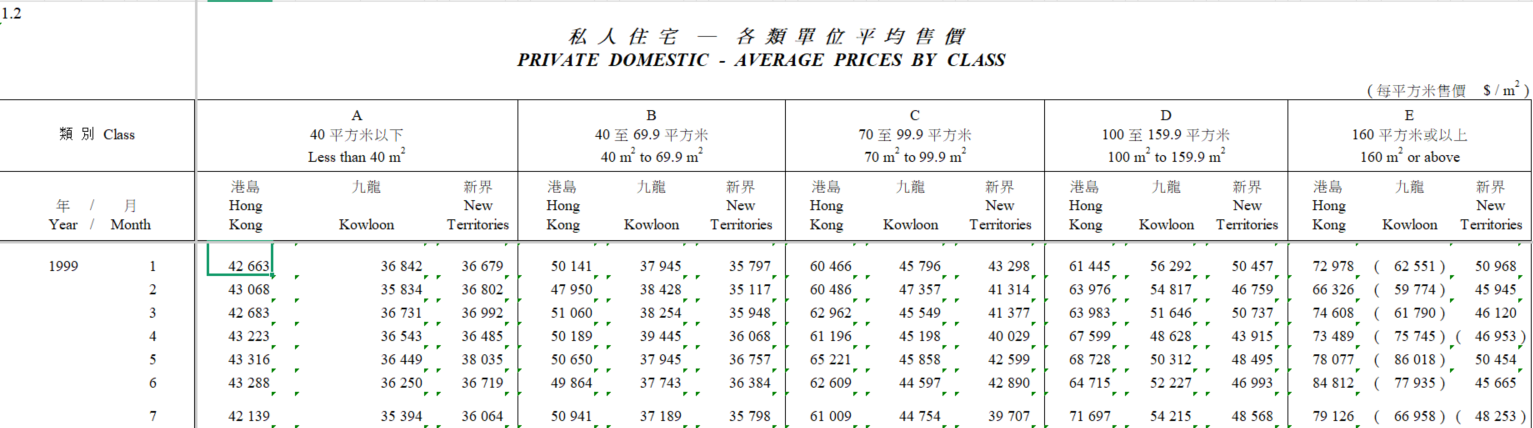

# Import all Library

In [22]:
import numpy as np
import statistics as stats
import pandas as pd
# Show all columns (no truncation)
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# Import data from RVD

In [9]:
url = 'https://www.rvd.gov.hk/doc/en/statistics/his_data_1.xls'
url2 = 'https://www.rvd.gov.hk/doc/en/statistics/his_data_2.xls'
df_price = pd.read_excel(url2)
df_rent = pd.read_excel(url)
df_price.head()

,1.2,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
0,私 人 住 宅 ─ 各 類 單 位 平 均 售 價,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRIVATE DOMESTIC - AVERAGE PRICES BY CLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,( 每平方米售價 $ / m2 )
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,類 別 Class,NaN,NaN,NaN,NaN,NaN,NaN,40 平方米以下,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 至 69.9 平方米,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70 至 99.9 平方米,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100 至 159.9 平方米,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160 平方米或以上,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Data processing and cleaning  

In [11]:
def data_processing(df):
  # Keep only rows that contain at least one numeric value
  df2 = df[9:327].dropna(axis=1, how='all') # drop columns with all NaN values

  # Keep only columns that contain at least one numeric value
  df2_num = df2.apply(pd.to_numeric, errors='coerce')
  cols_with_numbers = df2_num.columns[df2_num.notna().any()]

  # Subset original DataFrame to keep only these columns
  df_filtered = df2[cols_with_numbers]
  df_filtered.head()

  # Rename the columns to make them more readable
  classes = ['below40', 'below69', 'below99', 'below159', 'above160']
  areas = ['HK', 'KL', 'NT']

  new_columns = ['Year', 'Month']
  for cls in classes:
      for area in areas:
          new_columns.append(f'{area}_{cls}')

  df_filtered.columns = new_columns

  #data cleaning
  df_filtered = df_filtered.copy()
  df_filtered['Year'] = df_filtered['Year'].astype(str).str.strip().replace('', np.nan)
  df_filtered['Year'] = df_filtered['Year'].astype(str).str.strip().replace('nan', np.nan)
  # Fill Year forward (since only the first row of each year is filled)
  df_filtered['Year'] = df_filtered['Year'].ffill()
  # Create a datetime column
  df_filtered['Date'] = pd.to_datetime(df_filtered['Year'].astype(int).astype(str) + '-' + df_filtered['Month'].astype(int).astype(str), format='%Y-%m')

  # Set as index
  df_filtered = df_filtered.set_index('Date')
  return df_filtered

df_rent = data_processing(df_rent)
df_price = data_processing(df_price)
df_price.head()

,Year,Month,HK_below40,KL_below40,NT_below40,HK_below69,KL_below69,NT_below69,HK_below99,KL_below99,NT_below99,HK_below159,KL_below159,NT_below159,HK_above160,KL_above160,NT_above160
Date,,,,,,,,,,,,,,,,,
1999-10-01,1999,10.0,39151.0,34207.0,34079.0,47020.0,34568.0,33359.0,57482,42809.0,42504.0,64406.0,49622.0,47862.0,81675,58853,44525.0
1999-11-01,1999,11.0,38034.0,33152.0,32165.0,44567.0,34859.0,32581.0,57161,41374.0,39227.0,63750.0,46111.0,45452.0,80433,106211,52201.0
1999-12-01,1999,12.0,39408.0,34339.0,33419.0,48034.0,36934.0,32523.0,58886,42386.0,40687.0,65295.0,47200.0,44315.0,81539,87765,47884.0
2000-01-01,2000,1.0,39443.0,33390.0,34199.0,48927.0,35433.0,34248.0,59387,43041.0,39812.0,68049.0,47369.0,46486.0,82998,83864,55588.0
2000-02-01,2000,2.0,40426.0,34402.0,33652.0,47088.0,34902.0,34038.0,61421,40086.0,38039.0,66025.0,49315.0,46877.0,76964,72174,32794.0


# Plotting Trend on Price and Rent

In [15]:
def Plotting_Trend(df, type):
  # Plotting Area Averages (HK, KL, NT)
  # Convert to numeric, errors become NaN
  df = df.apply(pd.to_numeric, errors='coerce')
  areas = ['HK', 'KL', 'NT']
  for area in areas:
      cols = [col for col in df.columns if col.startswith(f'{area}_')]
      df[f'{area}_avg'] = df[cols].mean(axis=1)

  plt.figure(figsize=(12, 6))
  for area in areas:
      plt.plot(df.index, df[f'{area}_avg'], label=area)

  plt.xlabel("Date")
  plt.ylabel("Area Average")
  plt.title(f"House {type} Area Average Over Time")
  plt.legend()
  plt.show()

  # Plotting Class Averages (40, 69, 99, 159, 160)
  classes = ['below40', 'below69', 'below99', 'below159', 'above160']

  for cls in classes:
      cols = [col for col in df.columns if col.endswith(f'_{cls}')]
      df[f'{cls}_avg'] = df[cols].mean(axis=1)

  plt.figure(figsize=(12, 6))
  for cls in classes:
      plt.plot(df.index, df[f'{cls}_avg'], label=f'{cls} m²')

  plt.xlabel("Date")
  plt.ylabel("Class Average")
  plt.title(f"House {type} Class Average Over Time")
  plt.legend()
  plt.show()

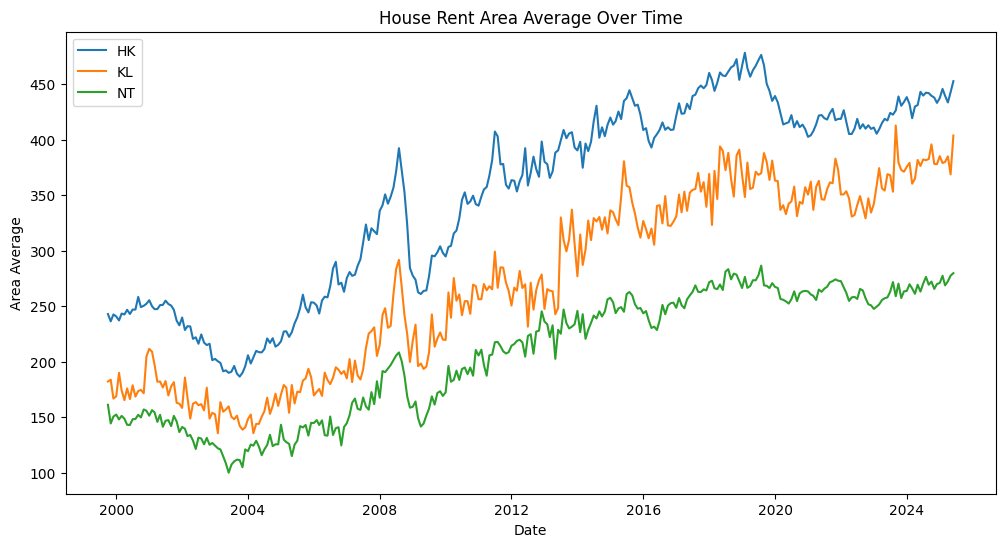

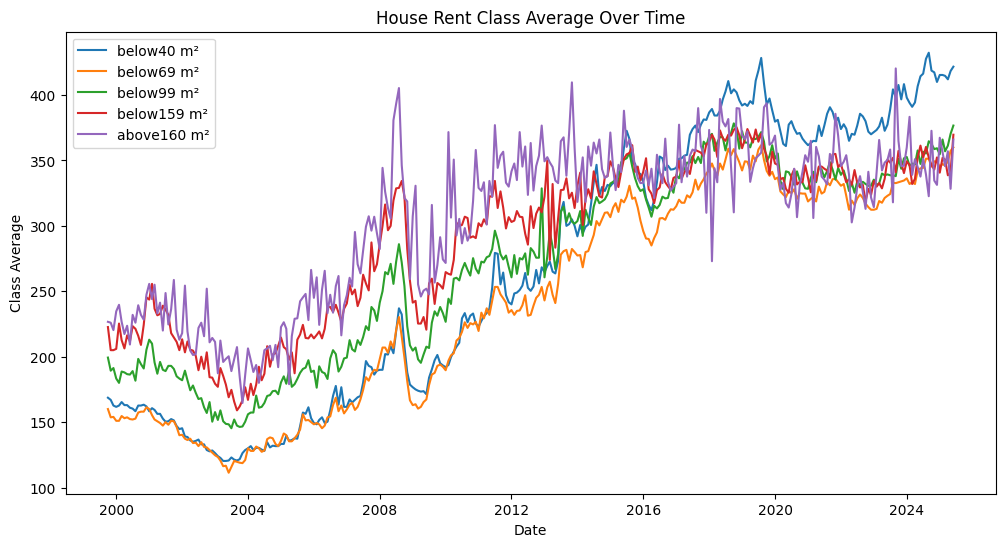

In [18]:
Plotting_Trend(df_rent,type='Rent')

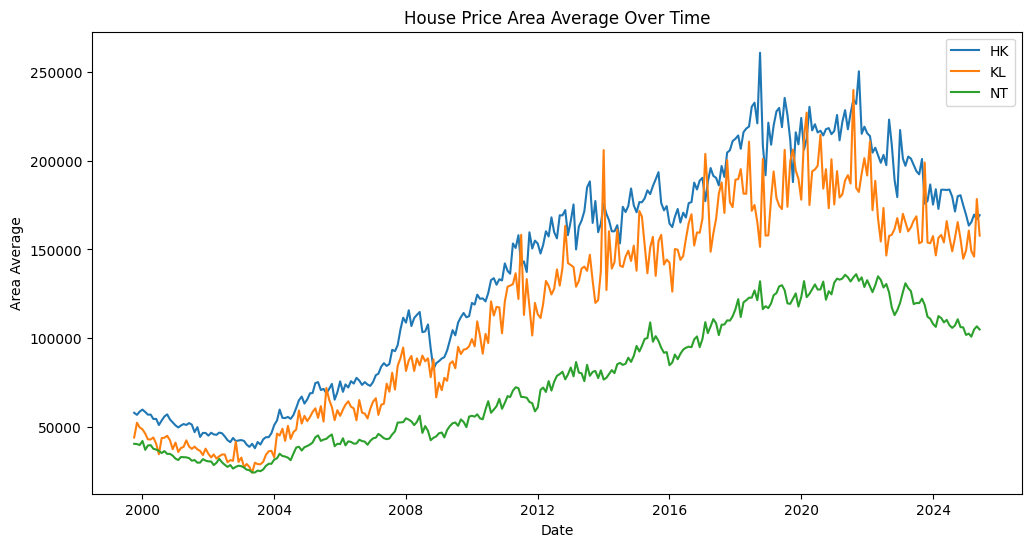

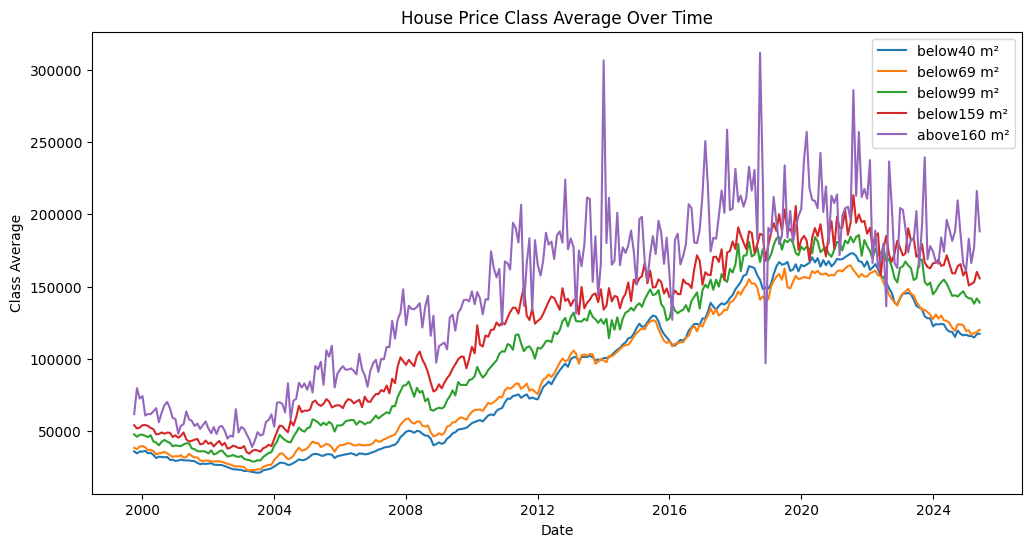

In [19]:
Plotting_Trend(df_price,type='Price')

## Data Anaylsis on HK House Price and Rent
Combining the Trend from House Rent and Price, we can obersve that:

* The price fluctuations of large-area units are higher than those of small-area units.
* The overall housing prices have fallen since 2018, but the rents have continued to rise rapidly.
* In terms of regions, the prices of Hong Kong Island have always been higher than those of Kowloon and the New Territories.
* In terms of rents, the rents of small units have risen rapidly, but at the same time, the prices of small units have fallen to the lowest level.

It is estimated that：
* Hong Kong's housing demand has always been strong, and the recent talent recruitment program from the mainland has led to a continuous increase in house rent.
* However, at the same time, Hong Kong's housing prices are relatively high, and a bubble is rapidly forming. The combined impact of these two factors has caused property prices to fall, but rents have continued to rise.
* As a result, ordinary middle-class residents have been renting small units with low rent, which has pushed small unit rents to the highest level. However, the market demand for small units has also declined.

# Machine Learing with SARIMA on House Price and Rent

In [28]:
def predict_house_price(target_series,type):
    if isinstance(target_series.index, pd.DatetimeIndex):
        target_series = target_series.asfreq('MS')
    #target_series = target_series.dropna()

    # Fit and forecast with best SARIMA
    model = SARIMAX(target_series, order=(1,1,2), seasonal_order=(1,1,1,12))
    result = model.fit()
    forecast = result.forecast(steps=12)

    # Plot actual vs forecast
    plt.figure(figsize=(12,6))
    plt.plot(target_series, label='Actual')
    plt.plot(forecast.index, forecast, 'r--', label='Forecast')
    plt.title(f'SARIMA Forecast for HK House {type} Trend')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

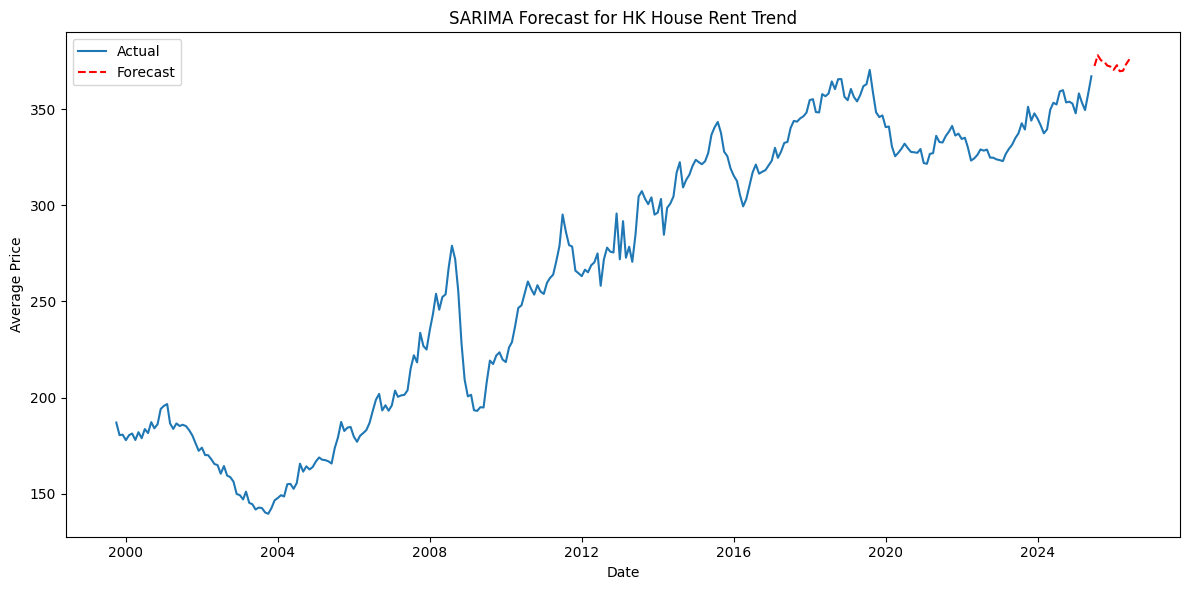

In [30]:
df_rent['all_avg'] = df_rent.select_dtypes(include='number').mean(axis=1)
target_series = df_rent['all_avg']
predict_house_price(target_series,type = 'Rent')

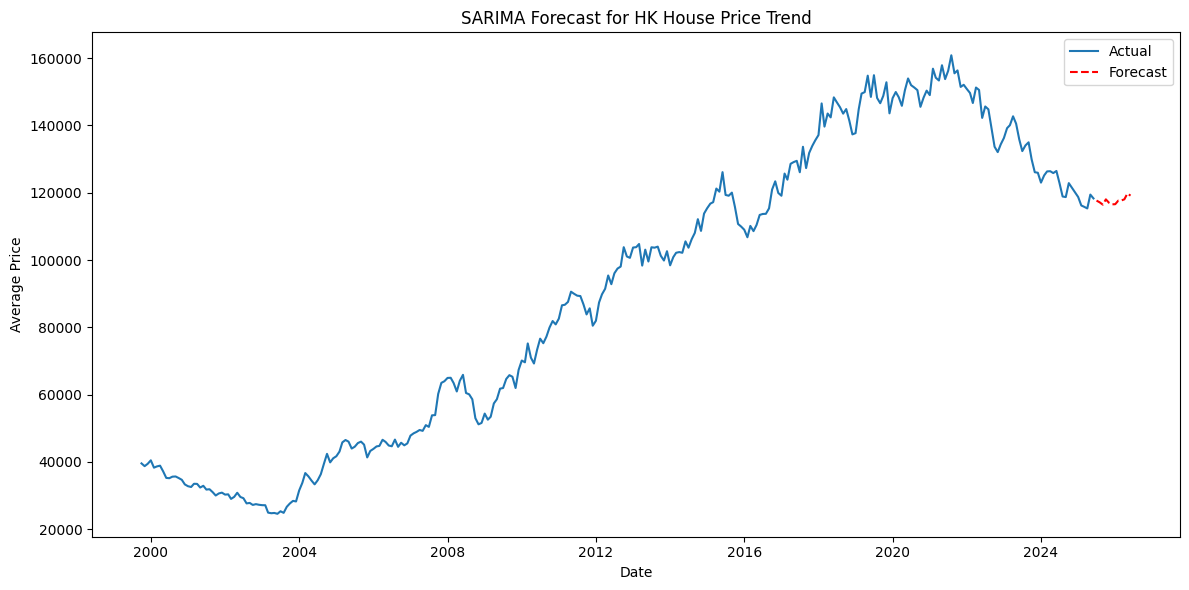

In [31]:
df_price['all_avg'] = df_price.select_dtypes(include='number').mean(axis=1)
target_series = df_price['all_avg']
predict_house_price(target_series,type = 'Price')

# Conclusion

This assignment selected **ARIMA** over LSTM (the training result is a flat line) based on the quantity and sparsity of the data. This method can **better capture the cyclical trends of the HK house price and rent trends.**
* Based on the prediction results of machine learning, Hong Kong's housing rental demand is strong and will steadily increase. Hong Kong's housing prices have entered a period of first falling and then stabilizing. There is a chance that house price will gradually recover as housing rental demand is expected to stabilize.

# Disclaimer
* Of course, this prediction has limitations and is for reference only. Future optimization directions may include adding other feature data, such as region, unit, and building age. The above machine prediction results are for reference only.